# Kodowanie obrazów za pomocą "programów" w Gimpie

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from src.coding.coding import RandomEncoder, RandomDecoder
import random
import os

IMAGES_PATH = '../data/image/scaled_images/'

def random_img():
    return random.choice(os.listdir(IMAGES_PATH))

def show_img(img_path):
    image_data = plt.imread(os.path.join(IMAGES_PATH, img_path))[:,:,:3]
    plt.imshow(image_data)

Using TensorFlow backend.


In [2]:
encoder = RandomEncoder()
decoder = RandomDecoder()

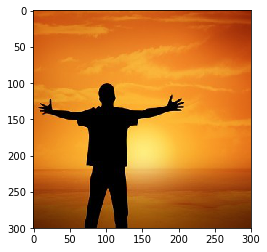

In [35]:
img_path = random_img()
show_img(img_path)

In [ ]:
encoded = encoder.encode(img_path, actions=170, size=50, render=True, to_bytes=True)

In [31]:
print(encoded[0:100])

b'\x00\x00\x02\xe4\x00\x00\x00\r\x00\x00\x00\t\x00\x00\x00\x0e\x00\x00\x00\x0c\x00\x00\x00\x12\x00\x00\x00\x07\x00\x00\x00\x0c\x00\x00\x00\x0e\x00\x00\x00\x10\x00\x00\x00\x0b\x00\x00\x00\r\x00\x00\x00\x0f\x00\x00\x00\x12\x00\x00\x00\x10\x00\x00\x00\x13\x00\x00\x00\x06\x00\x00\x00\x11\x00\x00\x00\x0f\x00\x00\x00\x11\x00\x00\x00\x0b\x00\x00\x00\t\x00\x00\x00\x11\x00\x00\x00\x0e\x00\x00\x00\r'


decompressed to 4444 bytes
decompressed in 3.6904137134552 sec


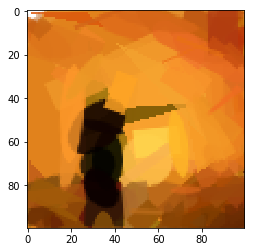

In [37]:
decoder.decode(encoded, size=100, from_bytes=True)

**obrazek wejściowy ~ size x size x 3 bitów** (30000 bitów dla obrazka 100x100)    
**obrazek zakodowany ~ actions x 44 bitów** (4400 bitów dla 100 akcji)   
### compression ratio
$$0,06818 \cdot \frac{size^2}{actions}$$
Dla obrazka 100x100 i 100 akcji = 6,818     
Skoro compression ratio zależy od ilości wykonanych akcji, istnieje maksymalna wartość, którą możemy użyć, aby skompresowany obrazek był mniejszy od obrazka wejściowego.   
$$maxActions=ceil(0.06818 \cdot size^2-1)$$
Dla obrazka 100x100 = 681      
Dla obrazka 300x300 to już 6136
### compression speed
Czas kompresji rośnie nieliniowo (o wiele szybciej) względem ilości akcji. Nie jestem w stanie wyprowadzić na to wzoru. Dłuższy czas dla "późniejszych" akcji spowodowany jest tym, że im bardziej obrazek przypomina obrazek źródłowy, tym trudniej (a co za tym idzie wolniej) znaleźć jest akcję która go jeszcze bardziej poprawi.    
TODO: Zrób ze dwa obrazki z fajną dokładnością tak żeby już były skompresowane, bo pokazywanie jak się one kompresują zajęłoby za dużo czasu
### decompression speed
TODO
(Zrób kilka testów dla 1,2,3,4... akcji. Zapisz czasy i postaraj się wywnioskować ile zajmuje cxzas otwarcia pluginu itd a ile to jest faktyczna zmiana związana z większą ilością akcji. Wzór powienien mieć stałą związaną z tym co jest zawsze wykonywane.  




100x100 - 681 : 924s/10s   
100x100 - 686 : 686s/10s   
100x100 - 10 : 8s/2s   
100x100 - 200 : 131s/4s   
     
11: 484 - 1376   
100: 4400 - 4582   
200: 8800 - 8120   

**Dekompresja do dowolnego rozmiaru** 

## Dodatkowa kompresja

In [190]:
print(encoded[0])
encoded_bytes = encoded.astype(np.float32).tobytes()
print(len(encoded_bytes))
print(encoded_bytes[0:10])
with open('/tmp/encoded_bytes', 'wb') as f:
    f.write(encoded_bytes)

[0.         0.26628272 0.13685483 0.32350611 1.         0.44603176
 0.36804522 0.95329562 0.55159935 0.79604569 0.        ]
8800
b'\x00\x00\x00\x005V\x88>\xac#'


In [191]:
with open('/tmp/encoded_bytes_after_ac', 'rb') as f:
    encoded_bytes_after_ac = f.read()
print(len(encoded_bytes_after_ac))

8120


In [193]:
with open('/tmp/decoded_bytes', 'rb') as f:
    decoded_bytes = f.read()
print(len(decoded_bytes))
print(decoded_bytes[0:10])
np.frombuffer(decoded_bytes, dtype=np.float32).reshape([200, 11])[0]

8800
b'\x00\x00\x00\x005V\x88>\xac#'


array([0.        , 0.2662827 , 0.13685483, 0.32350612, 1.        ,
       0.44603175, 0.3680452 , 0.9532956 , 0.5515993 , 0.7960457 ,
       0.        ], dtype=float32)

# Sieci konwolucyjne

In [138]:
from src.coding.coding import CnnEncoder, CnnDecoder
    
def load_data(name):
    path = "../data/dataset/shape_small/"
    X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
    Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")
    return X, Y

def show_source(i):
    plt.imshow(np.ones(X[i].shape) + X[i])

In [129]:
encoder = Encoder()
decoder = Decoder()

In [72]:
X, _ = load_data('test')

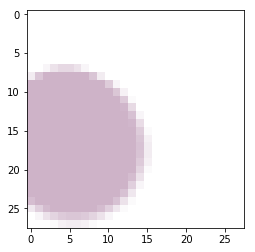

In [139]:
index = np.random.randint(0, X.shape[0])
show_source(index)

In [140]:
encoded = encoder.encode(X[index])
print(encoded)

compressed in 0.9737961292266846 secodns
(2, array([0.50772256, 0.29124847, 0.51851577, 0.46048453, 0.18481405,
       0.5772818 , 0.21570116, 0.6043281 , 0.53597105], dtype=float32))


decompressed in 2.5924344062805176 secodns


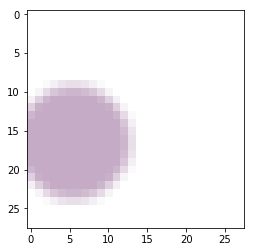

In [141]:
decoder.decode(encoded, size=28)

**obrazek wejściowy ~ 2352 bitów** (obrazek 28 x 28)   
**obrazek zakodowany ~ 44 bitów** (4 bity z numerem akcji + 40 bitów wektora argumentów)   
**compression ratio ~ 53,45** (dla jednej akcji) - czyli dla obrazka 28 x 28 ma to sens dla maksymalnie 53 akcji (można poprawić dodatkowo kompresując ciąg wektorów). Im większy obrazek, tym więcej akcji można wykonać, jednak ilość potrzebnych akcji do osiągnięcia podobnej precyzji jest proporcjonalna do wielkości.   
**compression speed ~ 2500 b/s** - przetwarzanie przez sieć neuronową (należy wziąć pod uwagę jednorazowy czas potrzebny na nauczenie sieci)
**decompression speed ~ 1000 b/s** - przetwarzanie w gimpie + zapis obrazka na dysk + ponowne wczytanie obrazka   
**dekompresja do dowolnego rozmiaru**   